In [1]:
from compute import Var, Par, Model, adda, addf, ureg, Evaluable, buildidpvars, get_unit
from compute import RefNode, INTER, addsolver
from scipy import interpolate
import numpy as np
import openmdao.api as om
import sympy as sp
from representations import render_tree, tree_incidence
from notation import generate_execution, graphs_from_incidence, make_acyclic, default_sequence
from datastructures import notation_from_tree, all_vars_from_incidence
from utils import normalize_name
from anytree import PreOrderIter
import matplotlib.pyplot as plt

In [2]:
from notationcompute import optsolver, solver, explicit

In [3]:
db2dec = lambda x: 10**(x/10)
dec2db = lambda x: 10*sp.log(sp.Abs(x), 10)

In [4]:
model = Model()
m = RefNode(name='/', ref=model)

# Geometry
D_d = Var('D_d', 5, 'm')
D_f = Var('D_f', 5, 'm')
D_s = Var('D_s', 1, 'm')
t_d = Var('t_d', 0.5, 'm')
t_f = Var('t_f', 2, 'm')
t_s = Var('t_s', 6, 'm')

P_hotel = Par('P_hotel', 50, 'W')
eta_s = Par('eta_s', 0.27)
phi_s = Par('phi_s', 800, 'W/m**2')
theta_bar = Par('theta_bar', 55, 'deg')
I_d = Par('I_d', 0.9)
D = Par('D', 0.005)
L_s = Par('L_s', 10)
t_r = Var('t_r', unit='hr')
E_AUV = Par('E_AUV', 1.9, 'kW*hr')
t_service = Par('t_service', 12, 'hr')
t_comms = Par('t_comms', 1, 'hr')
gamma = Par('gamma', 2)
A_s = adda(m, 'A_s', 1.5*(D_f/2)**2, 'm**2')
t_mission = Par('t_mission', 24, 'hr')

# AUV recharging system
P_recharge = adda(m, 'P_recharge', 
    eta_s * phi_s * sp.cos(theta_bar) * I_d * (1-D)**L_s * A_s, unit='W')
P_drawrecharge = adda(m, 'P_drawrecharge', P_hotel - P_recharge, unit='W')
E_recharge_gen = adda(m, 'E_recharge_gen', P_recharge * t_r, unit='W*hr')
E_service = adda(m, 'E_service', E_AUV * gamma, unit='W*hr')
P_service = adda(m, 'P_service', E_service / t_service, unit='W')
P_drawservice = adda(m, 'P_drawservice', P_hotel - P_service, unit='W')

# Propulsion
rho = Par('rho', 1023.6, 'kg/m**3') # density of seawater [kg/m^3]
C_d = Par('C_d', 1) # estimate drag coefficient (a square flat plate at 90 deg to the flow is 1.17)
S_w = Par('S_w', 0.5, 'm**2') # will technically need to determine from A_solar and other structural needs... assume something for now
v = Var('v', 0.3, 'm/s') # [m/s]
eta_m = Par('eta_m', 0.75) # estimated, need to determine from motors?
P_move = adda(m, 'P_move', rho*C_d*S_w*v**3/(2*eta_m), unit='W')

# Comms beginning
P_comms = Var('P_c', unit='W')

# Balances
E_required = adda(m, 'E_required', E_service + 
    (P_hotel + P_move)*t_mission + P_comms*t_comms, unit='W*hr')

R1 = addf(m, E_recharge_gen-E_required, name='R_1')

# Battery
mu_batt = Par('mu_batt', 30, 'W*hr/kg')
DOD = Par('DOD', 0.4)
eta_trans = Par('eta_trans', 0.85)
nu_batt = Par('nu_batt', 450, 'kW*hr/(m**3)')
N = Par('N', 1)
C = adda(m, 'C', E_service/(DOD*N*eta_trans), unit='kW*hr')
m_batt_zero = Par('m_batt_zero', 5, 'kg')
m_batt = adda(m, 'm_batt', C/mu_batt + m_batt_zero, unit='kg')
V_batt = adda(m, 'V_batt', C/nu_batt, unit='m**3')

# Comms
k = Par('k', 1.38065e-23, 'J/K')
c = Par('c', 3e8, 'm/s')
f = Par('f', 2.2, 'GHz')
lambd = adda(m, '\\lambda', c/f, unit='m')
eta_parab = Par('eta_parab', 0.55)
theta_t = Par('theta_t', 32)
error_t = Par('error_t', 27)
G_pt_db = adda(m, 'G_pt', 44.3-dec2db(theta_t**2))
L_pt_db = adda(m, 'L_pt_db', -12*(error_t/theta_t)**2)
G_t = adda(m, 'G_t', db2dec(G_pt_db+L_pt_db))
D_r = Par('D_r', 5.3, 'm')
G_rp = adda(m, 'G_rp', eta_parab*(np.pi*D_r/lambd)**2)
L_pr = Par('L_pr', db2dec(-0.1))
G_r = adda(m, 'G_r', G_rp*L_pr)
BER = Par('BER', 0.0001)
R = Var('R', unit='1/micros')
h = Par('h', 500, 'km')
Re = Par('Re', 6378, 'km')
T_s = Par('T_s', 135, 'K')
S = adda(m, 'S', sp.sqrt(h*(h+2*Re)), unit='km')
L_a = Par('L_a', db2dec(-0.3))
L_sp = adda(m, 'L_sp', (lambd/(4*np.pi*S))**2)
L_l = Par('L_l', db2dec(-1))
EN = adda(m, 'EN', P_comms*L_a*L_sp*L_l*L_pr*G_r*G_t/(k*T_s*R))
EN_req = Par('EN_{req}', 30)

R2 = addf(m, EN-EN_req, name='R_2')

In [5]:
s1 = addsolver(m, [elt for elt in PreOrderIter(m) if elt.node_type==INTER], [(R1, t_r), (R2, R)], name='s1')

In [6]:
render_tree(m, display_type=True)

/               
└── s1, SOLVER  
    ├── f_{0}, INTER
    ├── f_{1}, INTER
    ├── f_{2}, INTER
    ├── f_{3}, INTER
    ├── f_{4}, INTER
    ├── f_{5}, INTER
    ├── f_{6}, INTER
    ├── f_{7}, INTER
    ├── f_{8}, INTER
    ├── f_{10}, INTER
    ├── f_{11}, INTER
    ├── f_{12}, INTER
    ├── f_{13}, INTER
    ├── f_{14}, INTER
    ├── f_{15}, INTER
    ├── f_{16}, INTER
    ├── f_{17}, INTER
    ├── f_{18}, INTER
    ├── f_{19}, INTER
    ├── f_{20}, INTER
    ├── f_{21}, INTER
    ├── R_1, END
    └── R_2, END


In [7]:
eqs, eqv, dout, dins = model.data_structures()

In [8]:
sequence_m = default_sequence(m)

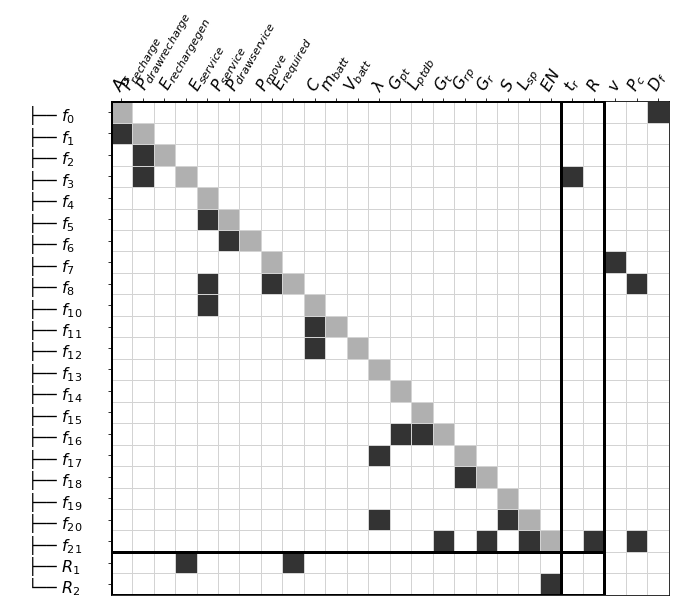

In [9]:
fig, ax = tree_incidence(m, eqv, model.outset, sequence_m, figsize=(10,10));
plt.sca(ax)
plt.savefig('figures/pearl.png', dpi=600, bbox_inches='tight')

In [199]:
eqs, eqv, dout, dins = model.data_structures()

In [200]:
notation = notation_from_tree(m, model.outset)

In [201]:
exec_instructions = generate_execution(notation)

In [202]:
for vr in all_vars_from_incidence(eqv, include_par=True):
    vr.name = normalize_name(vr.name, keep_underscore=True)
for fx in eqs.keys():
    fx.name = normalize_name(fx.name, keep_underscore=False)

In [203]:
prob = om.Problem()
opt_model = prob.model
groups = {0:opt_model}

In [204]:
buildidpvars(dins, opt_model)

In [205]:
inst_mapping = {
    'exp': lambda *args: explicit(groups, eqs, *args),
    'solver': lambda *args: solver(groups, eqs, maxiter=50, *args)
}

In [206]:
for comp_type, *comp_args in exec_instructions:
    inst_mapping[comp_type](*comp_args)

In [207]:
prob.setup();

In [208]:
prob.run_model()


group1
NL: Newton Converged in 5 iterations


In [209]:
optres = {key.name: prob.get_val(key.name)[0] for key in 
          all_vars_from_incidence(eqv, include_par=True)}

In [210]:
optres

{'theta_t': 32.0,
 'L_pt_db': -8.54296875,
 't_r': 5.251587803970661,
 'L_l': 0.7943282347242815,
 'P_drawrecharge': -944.2363696601083,
 'eta_trans': 0.85,
 'eta_parab': 0.55,
 'V_batt': 0.024836601307189544,
 'I_d': 0.9,
 'EN': 30.000000000000025,
 'A_s': 9.375,
 'gamma': 2.0,
 'eta_m': 0.75,
 'S_w': 0.5,
 't_mission': 24.0,
 'v': 0.3,
 'C_d': 1.0,
 'N': 1.0,
 'D_r': 5.3,
 'L_pr': 0.9772372209558107,
 'L_a': 0.933254300796991,
 'f': 2.2,
 'G_pt': 14.197000433601879,
 'phi_s': 800.0,
 'G_r': 8013.403775080155,
 't_service': 12.0,
 'c': 300000000.0,
 'S': 2574.490240804964,
 'DOD': 0.4,
 'G_rp': 8200.059927355664,
 'D': 0.005,
 'k': 1.38065e-23,
 'L_s': 10.0,
 'eta_s': 0.27,
 'P_drawservice': -266.6666666666667,
 'G_t': 3.6762341778646994,
 'nu_batt': 450.0,
 'L_sp': 1.776621526719071e-17,
 'E_required': 5221.319593171091,
 'mu_batt': 30.0,
 'm_batt_zero': 5.0,
 'D_f': 5.0,
 'E_AUV': 1.9,
 'Re': 6378.0,
 'P_service': 316.6666666666667,
 'T_s': 135.0,
 'rho': 1023.6,
 'R': 1.50527590241

In [4]:

# # Hydrodynamics
# rho_s = var('rho_s', 650, 'kg/m**3')

# h_f = var('h_f', 
#     t_f*rho_s/rho+((D_s/D_f)**2*t_s+(D_d/D_f)**2*t_d)*(rho_s/rho-1), 'm')
# z_g = var('z_g', 
#     (t_f*D_f**2/2-t_s*D_s**2/2-(t_s+t_d/2)*D_d**2)/(D_f**2+D_f**2+D_s**2)-h_f, 
#     'm')
# #Vol = var('Vol', np.pi/4*(h_f*D_f**2+t_s*D_s**2+t_d*D_d**2), 'm**3')
# #GM = var('GM', D_f**4/(16*(D_f**2*h_f+D_s**2*t_s+D_d**2*t_d))-(h_f+t_s+t_d)/2, 'm')


# def debugfx():
#     print('stop')
